In [1]:
import torch
from torch import nn 
import matplotlib.pyplot as plt
from IPython.display import Image 
#%matplotlib inline
import numpy as np
import dataset_utils
import time

In [2]:
torch.cuda.empty_cache()

In [3]:
import scipy.io as io
matdataset = io.loadmat("matlab_dataset/insect_dataset.mat")
all_imgs= torch.tensor(matdataset['all_images']).float().squeeze()
all_labels = torch.tensor(matdataset['all_labels']).float().squeeze()
imgs_1000 = all_imgs[0:1000]
imgs_1000.shape

torch.Size([1000, 3, 64, 64])

In [4]:
from DnaModel import TinyModel
tinymodel = TinyModel()
n_params = dataset_utils.count_trainable_parameters(tinymodel);
print(n_params)
state_dict = torch.load('checkpoints/CNN_DNA_weights_for_unseen')
tinymodel.load_state_dict(state_dict['model_state_dict'])

6452761


<All keys matched successfully>

In [5]:
import modelReACGAN as m
from utils import ops
import types
# configurations for ReACGAN

def define_modules(gan_config):
    layers = types.SimpleNamespace()
    if gan_config.apply_g_sn:
        layers.g_conv2d = ops.snconv2d
        layers.g_deconv2d = ops.sndeconv2d
        layers.g_linear = ops.snlinear
        layers.g_embedding = ops.sn_embedding
    else:
        layers.g_conv2d = ops.conv2d
        layers.g_deconv2d = ops.deconv2d
        layers.g_linear = ops.linear
        layers.g_embedding = ops.embedding

    if gan_config.apply_d_sn:
        layers.d_conv2d = ops.snconv2d
        layers.d_deconv2d = ops.sndeconv2d
        layers.d_linear = ops.snlinear
        layers.d_embedding = ops.sn_embedding
    else:
        layers.d_conv2d = ops.conv2d
        layers.d_deconv2d = ops.deconv2d
        layers.d_linear = ops.linear
        layers.d_embedding = ops.embedding

    if gan_config.g_cond_mtd == "cBN":
        layers.g_bn = ops.ConditionalBatchNorm2d
    elif gan_config.g_cond_mtd == "W/O":
        layers.g_bn = ops.batchnorm_2d
    else:
        raise NotImplementedError

    if not gan_config.apply_d_sn:
        layers.d_bn = ops.batchnorm_2d

    if gan_config.g_act_fn == "ReLU":
        layers.g_act_fn = nn.ReLU(inplace=True)
    elif gan_config.g_act_fn == "Leaky_ReLU":
        layers.g_act_fn = nn.LeakyReLU(negative_slope=0.1, inplace=True)
    elif gan_config.g_act_fn == "ELU":
        layers.g_act_fn = nn.ELU(alpha=1.0, inplace=True)
    elif gan_config.g_act_fn == "GELU":
        layers.g_act_fn = nn.GELU()
    elif gan_config.g_act_fn == "Auto":
        pass
    else:
        raise NotImplementedError

    if gan_config.d_act_fn == "ReLU":
        layers.d_act_fn = nn.ReLU(inplace=True)
    elif gan_config.d_act_fn == "Leaky_ReLU":
        layers.d_act_fn = nn.LeakyReLU(negative_slope=0.1, inplace=True)
    elif gan_config.d_act_fn == "ELU":
        layers.d_act_fn = nn.ELU(alpha=1.0, inplace=True)
    elif gan_config.d_act_fn == "GELU":
        layers.d_act_fn = nn.GELU()
    elif gan_config.g_act_fn == "Auto":
        pass
    else:
        raise NotImplementedError
    return layers
    
config = types.SimpleNamespace()
config.d_act_fn = "ReLU"
config.g_act_fn = "ReLU"
config.apply_d_sn= True
config.apply_g_sn= True
config.g_cond_mtd= "cBN"

l=define_modules(config)
discriminator = m.Discriminator(imsize:=64,128,True,True,[1],"D2DCE",2048,True,num_classes=1050,d_init="ortho",d_depth=2,mixed_precision=True,MODULES=l)
discriminator.cuda()

Discriminator(
  (blocks): ModuleList(
    (0): ModuleList(
      (0): DiscOptBlock(
        (conv2d0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
        (conv2d1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2d2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU(inplace=True)
        (average_pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
    )
    (1): ModuleList(
      (0): SelfAttention(
        (conv1x1_theta): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv1x1_phi): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv1x1_g): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv1x1_attn): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (softmax): Softmax(dim=-1)
      )
    )
    (2): Mo

In [6]:
import random
inference_times = []
for iteration in range(100):
    index = random.randint(0,all_imgs.shape[0]-1000)
    imgs_1000 = all_imgs[index:index+1000].cuda()
    with torch.no_grad():
        torch.cuda.synchronize()
        start_time = time.time()
        _ = discriminator.extract_features(imgs_1000,-1) # label is not needed because we're not training
        torch.cuda.synchronize()
        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)

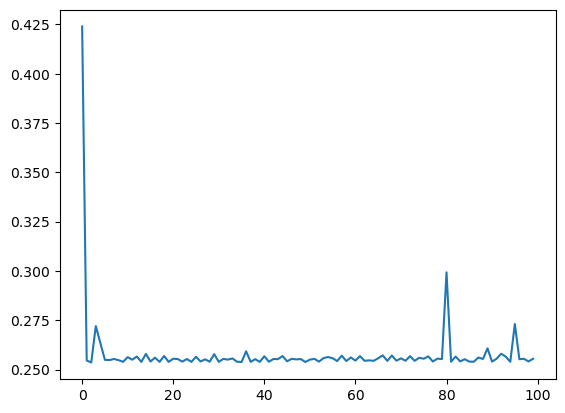

In [7]:
plt.plot(inference_times)

In [9]:
# discard first 10 runs to avoid JIT or cache effects
print(f"mean of inference times:{np.mean(inference_times[10:])}")
print(f"standard deviation of inference times:{np.std(inference_times[10:])}")

mean of inference times:0.25604057047102186
standard deviation of inference times:0.0051196577377117065


In [10]:
inference_times

[0.42395639419555664,
 0.25461339950561523,
 0.2536125183105469,
 0.27205514907836914,
 0.26347851753234863,
 0.25493836402893066,
 0.2548367977142334,
 0.2553904056549072,
 0.25478315353393555,
 0.25395965576171875,
 0.25631117820739746,
 0.25501275062561035,
 0.2566182613372803,
 0.2539181709289551,
 0.2579464912414551,
 0.25410962104797363,
 0.25605201721191406,
 0.25391077995300293,
 0.256868839263916,
 0.2539255619049072,
 0.2555365562438965,
 0.25533556938171387,
 0.2540585994720459,
 0.2553670406341553,
 0.25391459465026855,
 0.25652575492858887,
 0.2541353702545166,
 0.25519514083862305,
 0.25400400161743164,
 0.2578442096710205,
 0.25391483306884766,
 0.255434513092041,
 0.25505971908569336,
 0.25565361976623535,
 0.2539970874786377,
 0.25384020805358887,
 0.25928497314453125,
 0.253936767578125,
 0.25528764724731445,
 0.25393104553222656,
 0.25676846504211426,
 0.25400376319885254,
 0.2553749084472656,
 0.2553098201751709,
 0.25687217712402344,
 0.25420522689819336,
 0.255454